# Workshop Ghana: Choose Region & Calibrate Model

Welcome to the **eWaterCycle** Ghana workshop!

Since I am working on a CAMEL dataset, I made the data I already have available for you today.
I would, of course, love the opportunity to gather more data via your network.

Here you can choose a GRDC station from Ghana that we have downloaded, with which we can do HBV modelling!
This notebook will help you choose a certain region with the station ID.
After that you can manually calibrate the the model to fit your region and maybe even calibrate it for the research you want to do already!

**Please keep in mind** that I am looking for ways to improve our platform, if you found something difficult, let me know!
Also, what models do you want to see implemented so you can use the platform in your hydrological research

## Importing modules

Starting with all the libraries and utility functions. We have some general Python packages that we use.
And then the eWaterCycle packages, this is where we import our 'interface', models & our way of loading generalised forcings for all supported models.
Also I import some utility functions just for this notebook that I made to make it easier. (I kept the names there so you know what is going on!)

**NOTE** geopandas and folium will be installed, as they are not installed by default. But you will need to restart the kernel! Do this by going to the top-left "Kernel" --> "Restart Kernel..." *OR* click the "rewind" icon left of the "forward" icon, which is left of "Markdown".

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import importlib
import subprocess
import sys
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
from IPython.display import display
import json

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

# Check and install geopandas and folium
def install_if_missing(package_name):
    try:
        importlib.import_module(package_name)
        print(f"'{package_name}' is already installed.")
    except ImportError:
        print(f"'{package_name}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"PLEASE RESTART KERNEL")

install_if_missing("geopandas")
install_if_missing("folium")

import geopandas as gpd
import folium

# Utility functions
from util_functions import plot_hydrograph, interactive_plot, HBV, create_forcing_data_HBV_from_nc, load_data_HBV_local, get_station_names, stations_map

'geopandas' is already installed.

'folium' is already installed.

## Choosing your station

I am working on a CAMELS dataset for Ghana, Kenya and Zimbabwe.
I have uploaded the data I have available for Ghana to this server which you can use.
The markers represent the GRDC stations and the areas their shapefiles/catchments.

You can choose the station id from the interactive map!
Click on the shapefile are or the marker to copy the ID.

In [6]:
stations_dict = get_station_names()
stations_map(stations_dict)

## Calibration the HBV model

There are several ways to calibrate the model:
1. This simple interactive way, as you will see it quite hard to calibrate it properly.
2. Use a calibration algorithm, but this will take longer (and is less fun :) )

We are going to use a 'local' HBV model for this calibration, meaning that this is run in the cell itself, so it will not start up a container and work in the normal ways eWaterCyle works.

In [19]:
# Your CAMEL ID (yes sorry the .0 is necessary)
camel_id = "AF_1531450.0"

# Start & end date of your experiment
start_date = "1975-01-01T00:00:00Z"
end_date = "1979-12-31T00:00:00Z"

In [ ]:
# Make a settings file to store our settings
settings = dict()

settings["caravan_id"] = camel_id

In [20]:
# Custom function to create a data object, which will work with eWaterCycle
my_forcing = create_forcing_data_HBV_from_nc(start_date, end_date, camel_id)

# Parameters for the interactive calibrating
params = {
        'I_max': {'min': 0, 'max': 10},
        'Ce': {'min': 0.1, 'max': 1},
        'Su_max': {'min': 40, 'max': 800},
        'beta': {'min': 0.5, 'max': 5},
        'P_max': {'min': 0.001, 'max': 0.3},
        'T_lag': {'min': 1, 'max': 10},
        'Kf': {'min': 0.01, 'max': 0.2},
        'Ks': {'min': 0.0001, 'max': 0.01},
    }

# Rewrite the forcing for the interactive calibration plot, this is also used for the observed streamflow
calibrate_forcing = load_data_HBV_local(my_forcing)

# The interactive calibration plot
interactive_plot(HBV, calibrate_forcing, params)

Output()

In [21]:
# Add your parameters here, dont add the FM below, keep it at 0.001
parameters_found = [
    10.0,   # Imax - Interception capacity [mm]
    0.87,   # Ce - Soil runoff coefficient [-]
    592.0,  # Sumax - Max soil moisture storage [mm]
    1.4,    # Beta - Shape parameter for runoff generation [-]
    0.3,    # Pmax - Percolation threshold [mm/day]
    1.0,    # Tlag - Routing lag time [days]
    0.09,   # Kf - Fast runoff recession coefficient [1/day]
    0.01,   # Ks - Slow runoff recession coefficient [1/day]
    0.001   # FM - Snowmelt factor (not critical in Ghana, can remain low, but never 0)
]

In [ ]:
# Store the parameters found
settings["hbv_parameters"] = parameters_found

In [ ]:
# Write to a JSON file
with open("settings.json", "w") as json_file:
    json.dump(settings, json_file, indent=4)

## Setting up the model

Now that we have a calibrated model we can start to run things as they are supposed to.
Meaning a containerized model will be run on our supercomputer.

Below we show the core use of eWaterCycle: to users models are objects. We stay as close as possible to the standard BMI functions, but make sure that under the hood eWaterCycle makes everything run. Getting a model to run requires three steps:

1. creating a model object, an instance of the specific model class. This is provided by the different plugins. At the point of creation, the forcing object that will be used need to be passed to the model:

In [22]:
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

model = ewatercycle.models.HBV(forcing=my_forcing)

2. creating a configuration file that contains all the information the model needs to initialize itself.
   The format of the configuration file is very model specific. For example, the HBV configuration file contains information on:
  - the location of forcing files
  - the values of parameters and initial storages

In [23]:
config_file, _ = model.setup(parameters=parameters_found, initial_storage=s_0)

3. initializing starts the model container, creates all variables, and basically gets the model primed to start running.

In [24]:
model.initialize(config_file)

## Running the model
The basic loop that runs the model calls the ```model.update()``` to have the model progress one timestep and ```model.get_value()``` to extract information of interest. More complex experiment can interact with the model using, for example, ```model.set_value()``` to change values. In this way:

- multiple models can interact (including be coupled).
- models can be adjusted during runtime to incoming observations (ie. data assimilation).
- Effects not covered by the model can be calculated seperatly and included to create 'what if' experiments.
- and many more applications.

In [25]:
# Setting lists to fill with data in the model runs
Q_m = []
time = []

# The model run
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

After running the model we need to call ```model.finalize()``` to shut everything down, including the container. If we don't do this, the container will continue to be active, eating up system memory.

In [26]:
model.finalize()

## Checking our results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [27]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

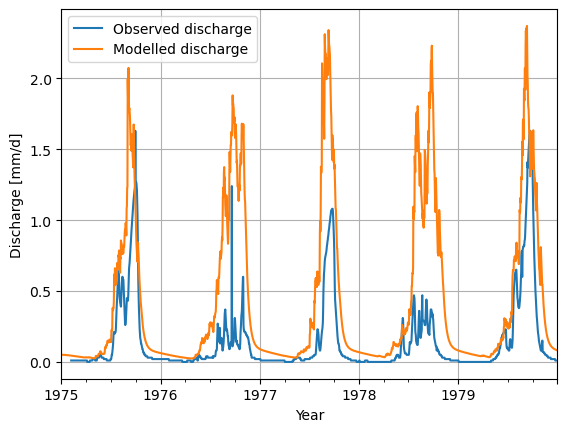

In [28]:
calibrate_forcing["Q"].plot(label="Observed discharge")
model_output.plot(label="Modelled discharge")

plt.legend()
plt.grid()
plt.ylabel("Discharge [mm/d]")
plt.xlabel("Year")
plt.show()